# AB Test

## Pre-Test: Design the test

Independent variable: landing page

Dependent variable: Converted

Significance alpha = 0.05 (confidence level is 95%)

2 Tailed test

Sample size --> Determine by power analysis


Goal: 
KPI: 3% --> 5% (2% increament for conversion rate)

In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import sem
import statsmodels.api as sm
import statsmodels.stats.power as power
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

## Sample size

Power Analysis
- alpha = 0.05
- power = 0.8
- effective size

In [2]:
effect_size = sm.stats.proportion_effectsize(0.03, 0.05)
power_ratio = 0.8
alpha = 0.05
sample_size = power.NormalIndPower().solve_power(effect_size=effect_size, alpha=alpha, power=power_ratio)
sample_size = int(math.ceil(sample_size))
print(f'The Test needs {sample_size} samples for both control and treatment group.')

The Test needs 1484 samples for both control and treatment group.


# Import Data

In [18]:
df = pd.read_csv('D:/Data Analysis/Projects/ab testing/ab_data.csv', parse_dates=['timestamp'])

## EDA & Preprocessing

In [19]:
print(df.info())
print('*'*50)

print(df.group.unique())
print('*'*50)

print(df.landing_page.unique())
print('*'*50)

print(pd.crosstab(df['group'], df['landing_page']))
print('*'*50)

print(df.user_id.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB
None
**************************************************
['control' 'treatment']
**************************************************
['old_page' 'new_page']
**************************************************
landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965
**************************************************
805339    2
754884    2
722274    2
783176    2
898232    2
         ..
64

In [8]:
# remove duplicates
counts = df['user_id'].value_counts()
print(counts.unique())
print(counts.head())

duplicate_list = counts[counts > 1].index
print(duplicate_list)

df = df[~df['user_id'].isin(duplicate_list)]
print(df.info())

[1]
851104    1
701718    1
646178    1
715222    1
886963    1
Name: user_id, dtype: int64
Int64Index([], dtype='int64')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 286690 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       286690 non-null  int64         
 1   timestamp     286690 non-null  datetime64[ns]
 2   group         286690 non-null  object        
 3   landing_page  286690 non-null  object        
 4   converted     286690 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 13.1+ MB
None


## Sampling

In [20]:
df_control = df[df['group'] == 'control'].sample(n=sample_size, random_state=10)
df_treatment = df[df['group'] == 'treatment'].sample(n=sample_size, random_state=10)

print(df_treatment.info())
print(df_control.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1484 entries, 35410 to 275094
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       1484 non-null   int64         
 1   timestamp     1484 non-null   datetime64[ns]
 2   group         1484 non-null   object        
 3   landing_page  1484 non-null   object        
 4   converted     1484 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 69.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1484 entries, 113789 to 96289
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       1484 non-null   int64         
 1   timestamp     1484 non-null   datetime64[ns]
 2   group         1484 non-null   object        
 3   landing_page  1484 non-null   object        
 4   converted     1484 non-null   int64         
d

In [21]:
# concat two df
df_sample = pd.concat([df_control, df_treatment])
df_sample.reset_index(drop=True, inplace=True)
print(df_sample)

      user_id                  timestamp      group landing_page  converted
0      676180 2017-01-16 19:09:08.287087    control     old_page          0
1      672641 2017-01-08 15:07:32.333099    control     old_page          0
2      850786 2017-01-07 15:12:46.888378    control     old_page          0
3      659451 2017-01-18 16:09:49.234681    control     old_page          1
4      937178 2017-01-19 00:16:20.229199    control     old_page          0
...       ...                        ...        ...          ...        ...
2963   935763 2017-01-17 19:34:43.794266  treatment     new_page          0
2964   928864 2017-01-04 06:22:11.071003  treatment     new_page          0
2965   707979 2017-01-14 19:34:55.828007  treatment     new_page          0
2966   802395 2017-01-23 22:32:06.115912  treatment     new_page          0
2967   655565 2017-01-10 02:02:35.032188  treatment     new_page          0

[2968 rows x 5 columns]


           Conv_Rate       Std       Str
group                                   
control     0.125337  0.331212  0.008598
treatment   0.119272  0.324218  0.008416


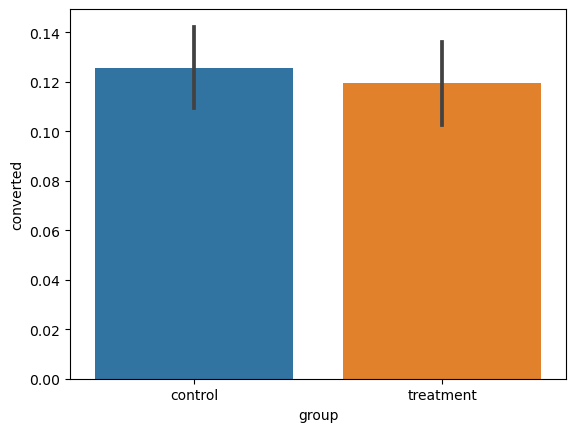

In [11]:
# calculate conversion rate
conv = df_sample.groupby(['group'])['converted']
summary = conv.agg([np.mean, np.std, sem])
summary.columns = ['Conv_Rate', 'Std', 'Str']
print(summary)

sns.barplot(x=df_sample['group'], y=df_sample['converted'])
plt.show()

In [15]:
# significantly different?
control_result = df_sample[df_sample['group'] == 'control']['converted']
treatment_result = df_sample[df_sample['group'] == 'treatment']['converted']

control_num = control_result.count()
treatment_num = treatment_result.count()

z_stat, pvalue = proportions_ztest([control_result.sum(), treatment_result.sum()], [control_num, treatment_num])

if pvalue > 0.05:
    print(f"{pvalue}>0.05, Fail to reject Null hypoethesis, AB groups are similar")
else:
    print(f"{pvalue}<0.05, reject Null hypoethesis, AB groups are not similar")

0.6141090608325716>0.05, Fail to reject Null hypoethesis, AB groups are similar


In [17]:
# Has the conversion rate raise in the treatment? If so, what %
(lb_control,lb_treatment), (ub_control,ub_treatment) = proportion_confint([control_result.sum(), treatment_result.sum()], [control_num, treatment_num], alpha = 0.05)
print(f'Lowerbound for control is {lb_control:.4f} | Upperbound for control is {ub_control:.4f}')
print(f'Lowerbound for treatment is {lb_treatment:.4f} | Upperbound for treatment is {round(ub_treatment, 4)}')

Lowerbound for control is 0.1085 | Upperbound for control is 0.1422
Lowerbound for treatment is 0.1028 | Upperbound for treatment is 0.1358
